# **Machine Learning on Big Data using PySpark**

---


# **Initiate and Configure Spark**

In [ ]:
# Using ! to execute a command in the command line or terminal
# Using pip3 to interact with the Python package manager for Python 3.x
# Using install to specify that we want to install a package
# Install the PySpark library, which is the Python API for Apache Spark


!pip3 install pyspark



# **Configure Google Drive**

In [ ]:
from google.colab import drive

# Mounting the Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession

# Creating a SparkSession named 'spark' to interact with Spark
# The 'master' parameter is set to "local[*]", which means Spark will run in local mode using all available cores
# The 'appName' parameter is set to 'Loan Credit' to give a name
# The 'getOrCreate()' method ensures that if an existing SparkSession is available, it will be reused; otherwise, a new one will be created


spark = SparkSession.builder \
        .master("local[*]") \
        .appName('Loan Credit') \
        .config("spark.driver.memory", "14g") \
        .config("spark.kryoserializer.buffer.max", "1g") \
        .getOrCreate()

---
# **Data Loading and Preprocessing & Visualisation**
---

In [ ]:
# load spark dataframe
sdf = spark.read.csv('/content/drive/MyDrive/Loan_credit/loan_credit.csv',inferSchema=True, header =True)

# View available details in this spark dataframe
sdf.describe().show()


+-------+------------------+-------------------+------------------+-----------+------------+---------------+------------------+-----------------+-----------------+------------------+-----------------+---------------+----------------+--------------------+------------------+-----------------+--------------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+------------------+-------------------+---------------------------+------------------+-------

---
# **Data Cleaning**
---

In [ ]:
selected_df = sdf.select(
    "SK_ID_CURR",
    "TARGET",
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "OCCUPATION_TYPE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY"
)


In [ ]:
selected_df.show(5)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+--------------------+--------------------+-----------------+----------+-------------+-----------------+---------------+---------------+-------------------+------------------+-------------------+--------------------+---------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|OCCUPATION_TYPE|       EXT_SOURCE_1|      EXT_SOURCE_2|       EXT_SOURCE_3|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|
+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-----------------

In [ ]:
from pyspark.sql.functions import abs, round, col

# Handling Negative values
converted_df = selected_df.withColumn("AGE_YEARS", round(abs(col("DAYS_BIRTH")) / 365, 2)) \
                            .withColumn("DAYS_EMPLOYED_POSITIVE", abs(col("DAYS_EMPLOYED"))) \
                            .withColumn("DAYS_REGISTRATION_POSITIVE", abs(col("DAYS_REGISTRATION"))) \
                            .withColumn("DAYS_ID_PUBLISH_POSITIVE", abs(col("DAYS_ID_PUBLISH"))) \
                            .drop("DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH")

In [ ]:
converted_df.show(5)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+--------------------+--------------------+-----------------+---------------+-------------------+------------------+-------------------+--------------------+---------------------------+---------+----------------------+--------------------------+------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|OCCUPATION_TYPE|       EXT_SOURCE_1|      EXT_SOURCE_2|       EXT_SOURCE_3|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|AGE_YEARS|DAYS_EMPLOYED_POSITIVE|DAYS_REGISTRATION_POSITIVE|DAYS_ID_PUBLISH_POSITIVE|
+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+----------

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

# Check for missing values in each column
counts_missing = converted_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in converted_df.columns])
counts_missing.show()

# Check for missing values in any row
total_count = converted_df.rdd.map(lambda row: sum([1 for x in row if x == None])).sum()
print("Total missing values in DataFrame: {}".format(total_count))

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-------------------+------------------+-----------------+---------------+------------+------------+------------+--------------------+---------------------------+---------+----------------------+--------------------------+------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|OCCUPATION_TYPE|EXT_SOURCE_1|EXT_SOURCE_2|EXT_SOURCE_3|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|AGE_YEARS|DAYS_EMPLOYED_POSITIVE|DAYS_REGISTRATION_POSITIVE|DAYS_ID_PUBLISH_POSITIVE|
+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-----------

In [ ]:
# Handling the Missing values
from pyspark.sql.functions import mean

# We can drop 2 columns with large amount of missing values
sdf_cleaned = converted_df.drop("OCCUPATION_TYPE", "EXT_SOURCE_1")

# Impute missing values in numerical columns with the mean
mean_values = {col: sdf_cleaned.agg(mean(col)).first()[0] for col in ["EXT_SOURCE_2", "EXT_SOURCE_3", "AMT_ANNUITY", "AMT_GOODS_PRICE"]}
imputed_df = sdf_cleaned.na.fill(mean_values)


In [ ]:
counts_missing = imputed_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in imputed_df.columns])
counts_missing.show()

# Check for missing values in any row
total_count = imputed_df.rdd.map(lambda row: sum([1 for x in row if x == None])).sum()
print("Total missing values in DataFrame: {}".format(total_count))

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-------------------+------------------+-----------------+------------+------------+--------------------+---------------------------+---------+----------------------+--------------------------+------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|EXT_SOURCE_2|EXT_SOURCE_3|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|AGE_YEARS|DAYS_EMPLOYED_POSITIVE|DAYS_REGISTRATION_POSITIVE|DAYS_ID_PUBLISH_POSITIVE|
+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-------------------+------------------+-----------------+------------

In [ ]:
# Checking the Schema along with the types
imputed_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = false)
 |-- AMT_GOODS_PRICE: double (nullable = false)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- EXT_SOURCE_2: double (nullable = false)
 |-- EXT_SOURCE_3: double (nullable = false)
 |-- REGION_RATING_CLIENT: integer (nullable = true)
 |-- REGION_RATING_CLIENT_W_CITY: integer (nullable = true)
 |-- AGE_YEARS: double (nullable = true)
 |-- DAYS_EMPLOYED_POSITIVE: integer (nullable = true)
 |-- 

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StringType

# convert all the string features into numerical values
string_features=[field.name for field in imputed_df.schema.fields if isinstance(field.dataType, StringType)]

for feature in string_features:
    indexer = StringIndexer(inputCol=feature, outputCol=feature+"_numeric")
    imputed_df = indexer.fit(imputed_df).transform(imputed_df)
imputed_df = imputed_df.drop(*string_features)

imputed_df.show()

+----------+------+------------+----------------+----------+-----------+---------------+-------------------+-------------------+--------------------+---------------------------+---------+----------------------+--------------------------+------------------------+--------------------------+-------------------+--------------------+-----------------------+------------------------+---------------------------+--------------------------+-------------------------+
|SK_ID_CURR|TARGET|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|       EXT_SOURCE_2|       EXT_SOURCE_3|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|AGE_YEARS|DAYS_EMPLOYED_POSITIVE|DAYS_REGISTRATION_POSITIVE|DAYS_ID_PUBLISH_POSITIVE|NAME_CONTRACT_TYPE_numeric|CODE_GENDER_numeric|FLAG_OWN_CAR_numeric|FLAG_OWN_REALTY_numeric|NAME_INCOME_TYPE_numeric|NAME_EDUCATION_TYPE_numeric|NAME_FAMILY_STATUS_numeric|NAME_HOUSING_TYPE_numeric|
+----------+------+------------+----------------+----------+-----------+------

#  **Advanced Data Analysis and Exploraton**

Further data analysis and research have revealed that our dataset suffers from a class imbalance issue, where the minority class "Not Approve" represents only 8.1% of the data, whereas the majority class "Approve" dominates with 91.9%. This skewed distribution is illustrated in the pie chart below.


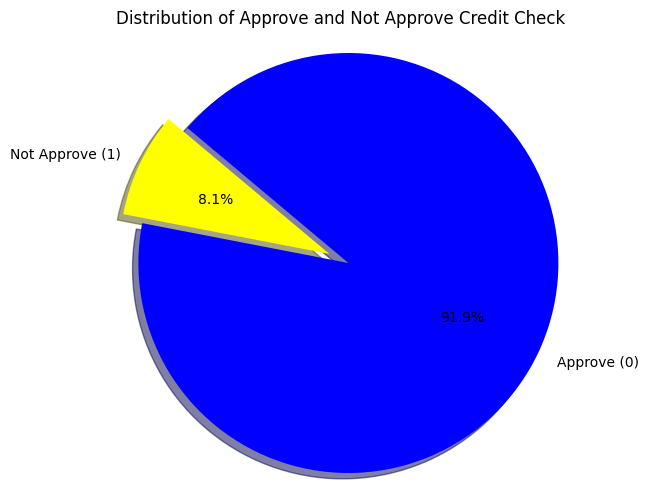

In [ ]:
import matplotlib.pyplot as plt

# Calculate counts of 1s and 0s
once_count = imputed_df.where(imputed_df["TARGET"] == 1).count()
zeros_count = imputed_df.where(imputed_df["TARGET"] == 0).count()

labels = 'Not Approve (1)', 'Approve (0)'
sizes = [once_count, zeros_count]
colors = ['yellow', 'blue']
explode_ratio = (0.1, 0)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode_ratio, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Approve and Not Approve Credit Check')
plt.show()
# print(sizes)

# **Class Imbalance Mitigation: SMOTE**

To address the class imbalance issue, we have chosen to employ the under-sampling method, a type of resampling technique. This approach involves reducing the size of the majority class (Approve) to match the size of the minority class (Not Approve), thereby balancing the class distribution. The resulting pie chart, shown below, illustrates the revised class balance after applying under-sampling to the imbalanced dataset.

In [ ]:
from pyspark.sql.functions import col
from imblearn.over_sampling import SMOTE
import pandas as pd

under_fraction = 0.15

# Under-sample the majority class (TARGET = 0)
undersampled_majority_df = imputed_df.where(col("TARGET") == 0).sample(False, under_fraction, seed=42)

# Cache the undersampled dataframe to optimize
undersampled_majority_df.cache()

# Extract minority class (TARGET = 1)
m_df = imputed_df.where(col("TARGET") == 1)

minority_df = undersampled_majority_df.union(m_df).toPandas()

# Separate features and target
X_minority = minority_df.drop(columns=['TARGET'])
y_minority = minority_df['TARGET']

# Apply SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_smote, y_smote = smote.fit_resample(X_minority, y_minority)

# Combine the SMOTE output with the target
smote_df = pd.DataFrame(X_smote, columns=X_minority.columns)
smote_df['TARGET'] = y_smote

# Convert the SMOTE df back to a Spark df
balanced_spark_df = spark.createDataFrame(smote_df)
balanced_df = balanced_spark_df

# Cache the balanced dataframe for better performance
balanced_df.cache()

DataFrame[SK_ID_CURR: bigint, CNT_CHILDREN: bigint, AMT_INCOME_TOTAL: double, AMT_CREDIT: double, AMT_ANNUITY: double, AMT_GOODS_PRICE: double, EXT_SOURCE_2: double, EXT_SOURCE_3: double, REGION_RATING_CLIENT: bigint, REGION_RATING_CLIENT_W_CITY: bigint, AGE_YEARS: double, DAYS_EMPLOYED_POSITIVE: bigint, DAYS_REGISTRATION_POSITIVE: double, DAYS_ID_PUBLISH_POSITIVE: bigint, NAME_CONTRACT_TYPE_numeric: double, CODE_GENDER_numeric: double, FLAG_OWN_CAR_numeric: double, FLAG_OWN_REALTY_numeric: double, NAME_INCOME_TYPE_numeric: double, NAME_EDUCATION_TYPE_numeric: double, NAME_FAMILY_STATUS_numeric: double, NAME_HOUSING_TYPE_numeric: double, TARGET: bigint]

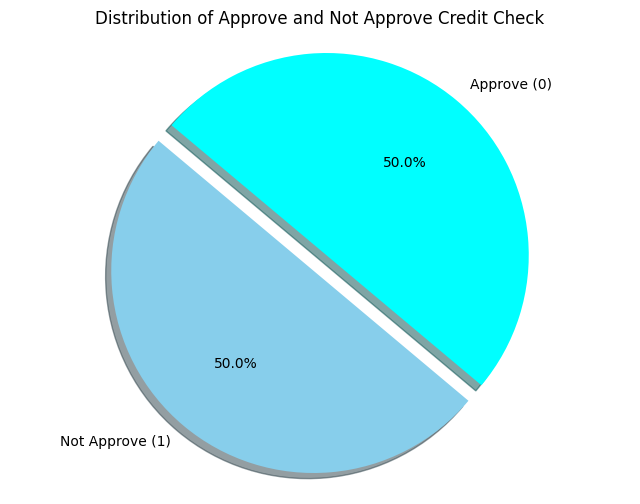

In [ ]:
once_count = balanced_df.where(balanced_df["TARGET"] == 1).count()
zeros_count = balanced_df.where(balanced_df["TARGET"] == 0).count()

labels = 'Not Approve (1)', 'Approve (0)'
sizes = [once_count, zeros_count]
colors = ['skyblue', 'cyan']
explode_ratio = (0.1, 0)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode_ratio, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Approve and Not Approve Credit Check')
plt.show()

# print(sizes)

In [ ]:
from pyspark.sql.functions import col, log1p
from pyspark.sql import functions as F

# Calculate skewness for each feature
skewness_df = balanced_df.select(
    [F.skewness(col(feature)).alias(feature) for feature in balanced_df.columns if feature != "TARGET"]
).toPandas()

# Define a threshold for skewness
skew_threshold = 1.0

# skewed features
skewed_features = skewness_df.columns[(skewness_df.abs() > skew_threshold).values[0]]
print(skewed_features)

# Apply log1p transformation to skewed features
for feature in skewed_features:
    balanced_df = balanced_df.withColumn(f"log_{feature}", log1p(col(feature)))

updated_features = [f"log_{feature}" if feature in skewed_features else feature for feature in balanced_df.columns if feature != "TARGET"]
print(updated_features)

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'DAYS_EMPLOYED_POSITIVE',
       'NAME_CONTRACT_TYPE_numeric', 'NAME_INCOME_TYPE_numeric',
       'NAME_EDUCATION_TYPE_numeric', 'NAME_FAMILY_STATUS_numeric',
       'NAME_HOUSING_TYPE_numeric'],
      dtype='object')
['SK_ID_CURR', 'log_CNT_CHILDREN', 'log_AMT_INCOME_TOTAL', 'log_AMT_CREDIT', 'log_AMT_ANNUITY', 'log_AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'AGE_YEARS', 'log_DAYS_EMPLOYED_POSITIVE', 'DAYS_REGISTRATION_POSITIVE', 'DAYS_ID_PUBLISH_POSITIVE', 'log_NAME_CONTRACT_TYPE_numeric', 'CODE_GENDER_numeric', 'FLAG_OWN_CAR_numeric', 'FLAG_OWN_REALTY_numeric', 'log_NAME_INCOME_TYPE_numeric', 'log_NAME_EDUCATION_TYPE_numeric', 'log_NAME_FAMILY_STATUS_numeric', 'log_NAME_HOUSING_TYPE_numeric', 'log_CNT_CHILDREN', 'log_AMT_INCOME_TOTAL', 'log_AMT_CREDIT', 'log_AMT_ANNUITY', 'log_AMT_GOODS_PRICE', 'log_DAYS_EMPLOYED_POSITIVE', '


# **Combine all the features in one single feature vector**
There are multiple approaches to creating a single feature vector, but we opt for the VectorAssembler method. This feature transformer accepts a range of input column types, including all numeric types, boolean, and vector types. In PySpark, VectorAssembler plays a crucial role in data preparation, especially when handling large-scale datasets.


In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=updated_features,outputCol="features")

# **Dataset Splitting into Traning and Testing Sets**

In [ ]:
from pyspark.ml.feature import StandardScaler

train, test = balanced_df.randomSplit([0.8, 0.2], seed=47)

# Transforms the features
standardscaler = StandardScaler(inputCol="features", outputCol="Scaled_features")

---
# **Model Selection and Implementation**

---


In this work, we have systematically selected and implemented two distinct prediction models, each tailored to address the specific requirements of loan credit risk assessment. By employing these models in tandem, we aim to develop a robust strategy that enhances the accuracy and efficiency of credit risk evaluation, ultimately contributing to a more secure and reliable financial environment.

The Random Forest Classifier is a pivotal component in our multi-model approach, renowned for its robustness and precision in evaluating loan creditworthiness. By harnessing the strengths of ensemble learning, this model significantly enhances the reliability and accuracy of our credit risk assessment system.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Define rf classifier
rf = RandomForestClassifier(labelCol="TARGET", featuresCol="Scaled_features")
rf_pipeline = Pipeline(stages=[assembler, standardscaler, rf])

Our Gradient-Boosted Trees (GBT) model is a game-changer in our multi-model approach. It's incredibly skilled at uncovering hidden patterns and complex relationships in the data, which helps us make more accurate predictions about loan credit risk. The way it works is by combining the strengths of multiple models, refining its predictions with each iteration, and continuously learning from the data. This adaptability is what makes GBT so valuable - it can handle a wide range of features and interactions, ensuring that our creditworthiness evaluations are precise and reliable. In short, GBT is a powerhouse that helps us make better decisions and provide more accurate assessments.

In [ ]:
from pyspark.ml.classification import GBTClassifier

# Define GBT classifier
gbt = GBTClassifier(labelCol="TARGET", featuresCol="Scaled_features")
gbt_pipeline = Pipeline(stages=[assembler, standardscaler, gbt])

---
# **Model Parameter Tuning**


---


Model parameter tuning is a crucial step in optimizing the performance of a machine learning model. This process involves adjusting the model's factors to achieve the best possible results. Hyperparameter tuning is a key aspect of this process, where different values are systematically tested for each parameter, and the combination that yields the highest performance on a validation set is selected. This iterative process ensures that the model is fine-tuned to make accurate predictions and improve its overall reliability.

To optimize the performance of our loan credit risk assessment models, we employed the robust technique of cross-validation (CV) to tune the model parameters. This method is instrumental in evaluating the generalizability and performance of machine learning models. By dividing the dataset into smaller subsets, known as folds, and iteratively training and testing the models on different combinations of training and testing datasets, CV provides a comprehensive assessment of the model's ability to generalize to unseen data. During the training process, a portion of the dataset is reserved as a test set to evaluate the model's performance on unseen data, which is the primary objective of CV. By applying CV to all three models, we ensured that the optimal parameters were selected to achieve the best possible performance.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Parameter grid
random_forest_params = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Cross-validation
rf_evaluator = BinaryClassificationEvaluator(labelCol="TARGET")
rf_crossval = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=random_forest_params, evaluator=rf_evaluator,numFolds=2)

# Find the best model
rf_cv_model = rf_crossval.fit(train)
rf_best_model = rf_cv_model.bestModel

# Make predictions
rf_predictions = rf_best_model.transform(test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Parameter grid
gbt_params = gbt_params = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10]) \
    .addGrid(gbt.maxDepth, [5]) \
    .addGrid(gbt.stepSize, [0.1]) \
    .build()


# Cross-validation
gbt_evaluator = BinaryClassificationEvaluator(labelCol="TARGET")
gbt_crossval = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=gbt_params, evaluator=gbt_evaluator, numFolds=2)

# Find the best model
gbt_cv_model = gbt_crossval.fit(train)
gbt_best_model = gbt_cv_model.bestModel

# Make predictions
gbt_predictions = gbt_best_model.transform(test)

---
# **Model Evaluation and Accuracy Calculation**
---

When building a classification model, we need to measure its performance. Here are four key metrics to help us do that:

**Accuracy**: How often is the model correct?

**Precision**: How many positive predictions are actually true?

**Recall**: How many actual positives are correctly identified?

**F1-Score**: A balanced measure of precision and recall.

In [ ]:
# Performance of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="TARGET")

# Set the evaluation metric names
evaluator.setMetricName("accuracy")
acc = evaluator.evaluate(rf_predictions)

evaluator.setMetricName("precisionByLabel")
precision = evaluator.evaluate(rf_predictions)

evaluator.setMetricName("recallByLabel")
recall = evaluator.evaluate(rf_predictions)

f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.7555358724534986
Precision: 0.7320875600640684
Recall: 0.8078237304112171
F1-Score: 0.7680932108447232


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator.setMetricName("accuracy")
acc = evaluator.evaluate(gbt_predictions)

evaluator.setMetricName("precisionByLabel")
precision = evaluator.evaluate(gbt_predictions)

evaluator.setMetricName("recallByLabel")
recall = evaluator.evaluate(gbt_predictions)

f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.7271922054915855
Precision: 0.7119833351606184
Recall: 0.7651702603982562
F1-Score: 0.7376192639709223


---
# **Results Visualization or Printing**
---

A powerful visualization is the key to unlocking the story behind the data, and it plays a vital role in the ongoing quest to detect, investigate, and prevent loan defaults, while also uncovering new opportunities to optimize lending strategies and improve customer relationships.

This Receiver Operating Characteristic (ROC) curve plots the True Positive Rate against the False Positive Rate at different thresholds, showcasing the performance of our RandomForest model in predicting loan creditworthiness.

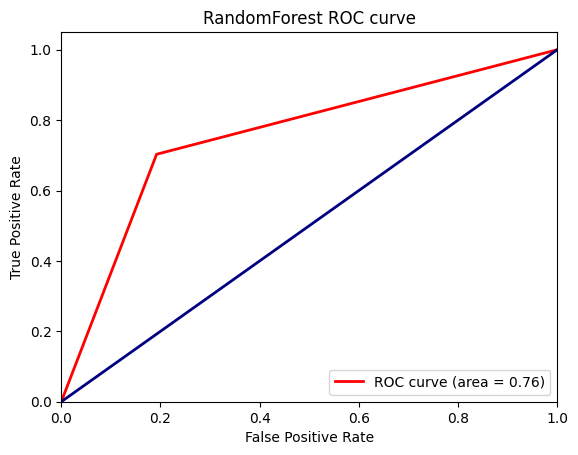

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# pandas df
y_true = rf_predictions.select("TARGET").toPandas()
y_prediction = rf_predictions.select("prediction").toPandas()


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC curve')
plt.legend(loc="lower right")
plt.show()

This Precision-Recall curve plots the trade-off between Precision (the proportion of true positives among all predicted positives) and Recall (the proportion of true positives among all actual positives) at different thresholds.

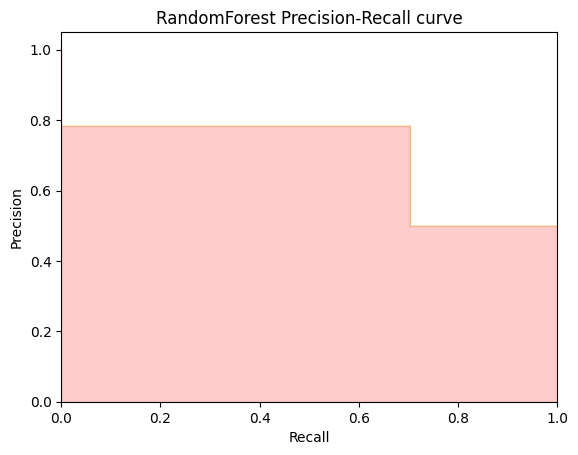

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_prediction)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='y', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('RandomForest Precision-Recall curve')
plt.show()

This Confusion Matrix displays the number of true positives (correctly predicted good loans), true negatives (correctly predicted bad loans), false positives (bad loans misclassified as good), and false negatives (good loans misclassified as bad) made by our RandomForest model. The diagonal elements represent the number of correct predictions, while off-diagonal elements represent the number of incorrect predictions. This matrix provides a summary of the model's performance and helps identify areas for improvement.

<Axes: >

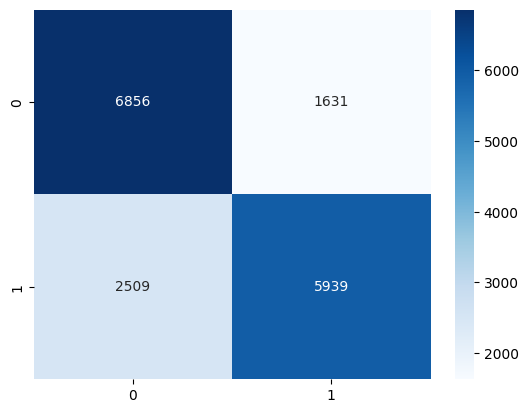

In [ ]:
# Confusion matrix
confusion_matrix = confusion_matrix(y_true, y_prediction)

sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

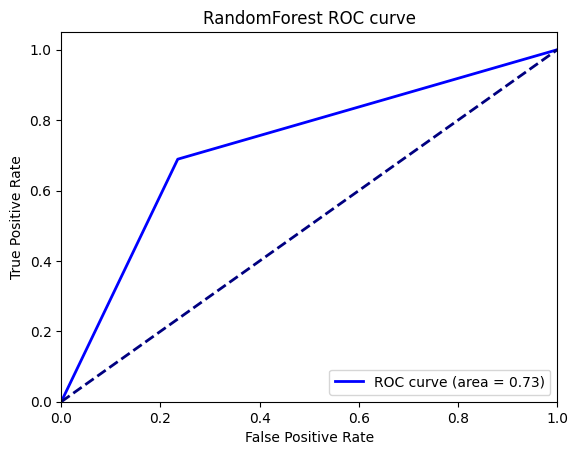

In [ ]:
y_true = gbt_predictions.select("TARGET").toPandas()
y_prediction = gbt_predictions.select("prediction").toPandas()


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC curve')
plt.legend(loc="lower right")
plt.show()

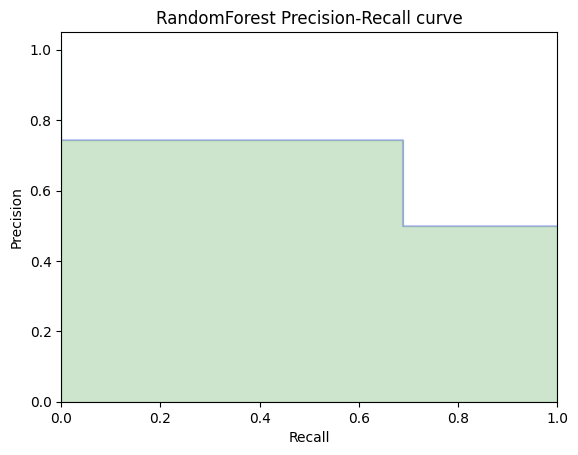

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_prediction)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('RandomForest Precision-Recall curve')
plt.show()

<Axes: >

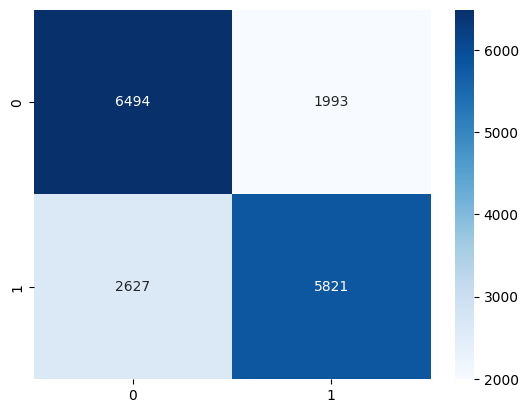

In [ ]:
from sklearn.metrics import confusion_matrix as cm

# Confusion matrix
conf_mat = cm(y_true, y_prediction)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")

---
# **LSEP Considerations**
---

#**Legal**

Our Loan Credit project prioritizes compliance with regulatory requirements, ensuring that our use of financial data is both responsible and secure. We've implemented robust data governance practices to safeguard sensitive information and maintain the trust of our stakeholders. By adhering to relevant laws and regulations, such as the FCRA and ECOA, we demonstrate our commitment to upholding the highest standards of data protection and privacy.

#**Social**

The Loan Credit project has the potential to make a meaningful impact on people's lives by providing more accurate and inclusive credit scoring. By leveraging advanced data analysis and machine learning techniques, we aim to create a more level playing field for individuals and businesses seeking access to credit. Our project promotes financial inclusion, economic opportunities, and social mobility, ultimately contributing to a more equitable society.

#**Ethical**

At the heart of our Loan Credit project is a deep commitment to ethics and fairness. We recognize the risks of bias in credit scoring models and have taken proactive steps to mitigate them. Our approach emphasizes transparency, accountability, and explainability, ensuring that our models are fair, reliable, and free from discriminatory practices. By prioritizing ethics, we build trust with our stakeholders and foster a more responsible and sustainable financial ecosystem.

#**Professional**

Our Loan Credit project showcases our expertise in data analysis, machine learning, and software development. We've applied cutting-edge techniques and tools to create a robust and scalable solution that meets the highest standards of quality and performance. Through our project, we demonstrate our ability to work collaboratively, think critically, and communicate complex ideas effectively, highlighting our professionalism and dedication to delivering exceptional results.

# **Report HTML template**


In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html
!jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030.ipynb

from nbconvert import HTMLExporter
import nbformat

notebook_filename = '/content/drive/MyDrive/Loan_credit/loan_credit.ipynb'

# Read the notebook
with open(notebook_filename, 'r', encoding='utf-8') as notebook_file:
    notebook_content = notebook_file.read()

# Convert notebook to HTML
notebook = nbformat.reads(notebook_content, as_version=4)
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook)

# Save the HTML content to a file
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as html_file:
    html_file.write(body)


[NbConvertApp] WARNING | pattern 'Your_Group_ID_CRWK_CN7030.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]